In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

import pymorphy2
import string
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('VKR_docs.csv')
#df = df.sample(50)
print('Количество документов:', len(df))
df.head()

Количество документов: 360


,path_doc,title,paragraphs_text,dict_paragraphs_text,all_text,faculty_department,faculty,department,degree
0,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ методов обеспечения безопасной передачи...,['Paragraph 0: ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБО...,"{0: 'ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА.', 1: '...",ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА. АНАЛИЗ МЕТО...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor
1,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ психологических типов сотрудников для м...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor
2,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Исследование влияния алгоритма стохастического...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor
3,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка VPN-приложения для мобильных устрой...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor
4,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка автоматизированной системы защиты и...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor


In [3]:
df['dict_paragraphs_text'] = df['dict_paragraphs_text'].map(eval)

### Анализ данных для предобработки

In [4]:
def simple_preproc_list_of_sentences(lst_sentences):
    lst_sentences_new = []
    for sent in lst_sentences:
        sent = ''.join(ch for ch in sent if ch not in string.punctuation).lower()
        sent = re.sub('\d', '', sent)
        sent = sent.rstrip().strip().lstrip()
        sent = ' '.join(nltk.RegexpTokenizer(r"\w+").tokenize(sent))
        sent = ' '.join(re.findall('[а-я]\w+', sent))
        lst_sentences_new.append(sent)
    return lst_sentences_new

In [5]:
# кажды параграф имеет некоторое количество предложений
# составим для каждого документа словарь со списком предложений

def get_paragraph_sents(dict_paragraphs):
    dict_paragraph_sents = {}
    for p, text in dict_paragraphs.items():
        dict_paragraph_sents[p] = simple_preproc_list_of_sentences(sent_tokenize(text))
    return dict_paragraph_sents

df['dict_paragraphs_sents'] = df['dict_paragraphs_text'].apply(lambda d: get_paragraph_sents(d))
df.head()

,path_doc,title,paragraphs_text,dict_paragraphs_text,all_text,faculty_department,faculty,department,degree,dict_paragraphs_sents
0,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ методов обеспечения безопасной передачи...,['Paragraph 0: ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБО...,"{0: 'ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА.', 1: '...",ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА. АНАЛИЗ МЕТО...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,"{0: ['выпускная квалификационная работа'], 1: ..."
1,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ психологических типов сотрудников для м...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...
2,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Исследование влияния алгоритма стохастического...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...
3,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка VPN-приложения для мобильных устрой...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...
4,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка автоматизированной системы защиты и...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...


In [6]:
# cocтавим словарь с количеством предложений в параграфе для каждого документа 

df['dict_count_paragraph_sents'] = df['dict_paragraphs_sents'].apply(lambda d: {p:len(sents) for p,sents in d.items()})   
df.head()

,path_doc,title,paragraphs_text,dict_paragraphs_text,all_text,faculty_department,faculty,department,degree,dict_paragraphs_sents,dict_count_paragraph_sents
0,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ методов обеспечения безопасной передачи...,['Paragraph 0: ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБО...,"{0: 'ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА.', 1: '...",ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА. АНАЛИЗ МЕТО...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,"{0: ['выпускная квалификационная работа'], 1: ...","{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ..."
1,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ психологических типов сотрудников для м...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ..."
2,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Исследование влияния алгоритма стохастического...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ..."
3,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка VPN-приложения для мобильных устрой...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ..."
4,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка автоматизированной системы защиты и...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ..."


<AxesSubplot:>

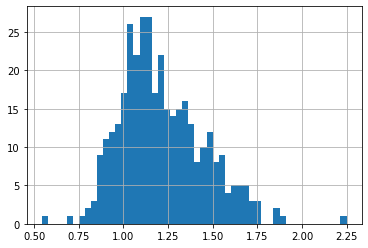

In [7]:
# посчитаем среднее количество предложений в параграфах

df['avg_count_paragraph_sents'] = df['dict_count_paragraph_sents'].apply(lambda d: np.mean(list(d.values())))
df['avg_count_paragraph_sents'].hist(bins=50)

In [8]:
# посмотрим какие предложения параграфов пофторяются в документах

dict_sents_count_docs = {}
for d in df['dict_paragraphs_sents'].values:
    set_doc_sents = set()
    for p, sents in d.items():
        for sent in sents:
            set_doc_sents.add(sent)
            
    for sentence in set_doc_sents:
        if sentence not in dict_sents_count_docs:
            dict_sents_count_docs[sentence] = 1
        else:
            dict_sents_count_docs[sentence] = dict_sents_count_docs[sentence] + 1

In [9]:
list(dict_sents_count_docs.keys())[:10]

['',
 'данной главе были рассмотрены пять протоколов прикладного уровня модели интернета вещей',
 'затем биржа направляет сообщения очередь которая связана биржей помощью специальных правил привязок',
 'дата выдачи задания декабря',
 'протокол предназначен для обмена данными режиме реального времени',
 'основная идея интернета вещей заключается потоке данных между устройствами простоте связи через большое число узлов',
 'протокол ориентирован на межсерверное взаимодействие на высокой скорости поддержкой основных механизмов безопасности',
 'таблице обозначение строке характеристик указывает на наличие данных характеристик предъявляемых соответствующему протоколу',
 'согласно апрельскому выпуску года журнала получив доступ примерно ста тысячам единиц устройств большим энергопотреблением например умным кондиционерам или нагревателям злоумышленники могут организовать крупномасштабную скоординированную атаку на электрическую сеть целого города',
 'рисунок взаимодействия использованием прото

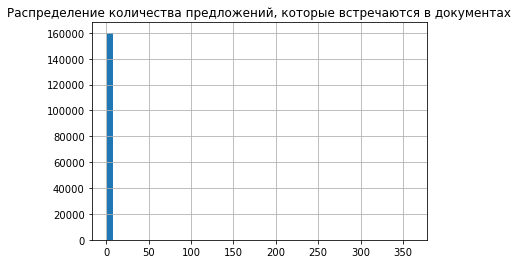

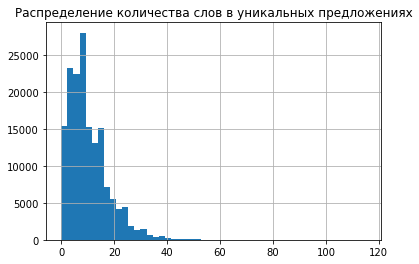



Количество уникальных предложений во всех документах: 160591
Количество всех слов во всех документах: 1651478


,sentence,count_docs_sents,count_words
213,выпускная квалификационная работа,360,3
0,,360,0
356,том числе источников по годам,358,5
75,квалификация бакалавр,358,2
172,введение,358,1
262,характеристика выпускной квалификационной работы,357,4
384,выпускной квалификационной работы,357,3
177,полное число источников использованных работе,356,5
240,на выпускную квалификационную работу,356,4
74,аннотация,356,1


In [10]:
# проведем небольшой анализ предложений в документах

df_sents_count_info = pd.DataFrame()
df_sents_count_info['sentence'] = list(dict_sents_count_docs.keys())

# количество документов, в которых содержатся данные предложения
df_sents_count_info['count_docs_sents'] = df_sents_count_info['sentence'].map(dict_sents_count_docs)
df_sents_count_info['count_words'] = df_sents_count_info['sentence'].apply(lambda x: len(x.split()))
df_sents_count_info = df_sents_count_info.sort_values(by = ['count_docs_sents', 'count_words'], ascending = False)


df_sents_count_info['count_docs_sents'].hist(bins=50)
plt.title('Распределение количества предложений, которые встречаются в документах')
plt.show()
print('\n')
df_sents_count_info['count_words'].hist(bins=50)
plt.title('Распределение количества слов в уникальных предложениях')
plt.show()
print('\n')
print('Количество уникальных предложений во всех документах:', len(df_sents_count_info))
print('Количество всех слов во всех документах:', df_sents_count_info['count_words'].sum())
df_sents_count_info.head(20)

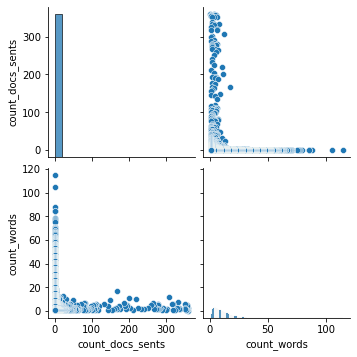

In [11]:
sns.pairplot(df_sents_count_info[['count_docs_sents', 'count_words']])

<AxesSubplot:>

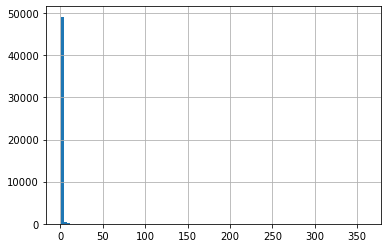

In [12]:
# распределение количества документов с одинаковыми предложениями, в которых не меньше 5 слов

df_sents_count_info[df_sents_count_info.count_words <= 5]['count_docs_sents'].hist(bins = 100)

In [13]:
# выделим те предложения,  которые содержаться более, чем в 60 документах (половина от всех документов)
# это предложения, которые встречаются чаще всего в ВКР для соблюдения структуры и не несут важной информации
# в зависимости от целей тематического моделирования такие предложения могут быть удалены или оставлены (пока удалять не будем)
# а также может быть проведен более детальный анализ слов, входящих в обязательную структуру документа

df_sents_count_info[(df_sents_count_info.count_docs_sents >= 60)]

,sentence,count_docs_sents,count_words
213,выпускная квалификационная работа,360,3
0,,360,0
356,том числе источников по годам,358,5
75,квалификация бакалавр,358,2
172,введение,358,1
...,...,...,...
292,обращения,63,1
6452,вкр принята июня,62,3
479,направление подготовки специальность информаци...,60,5
100117,описание предметной области,60,3


### Подготовка текста для тематического моделирования

In [14]:
def to_analysing_text(dict_paragraphs_sents):
    lst_text = []
    for paragraph in dict_paragraphs_sents.values():
        lst_text = lst_text + paragraph
        lst_text = [' '.join(sent.split()) for sent in lst_text if len(sent.split())>1]
    return lst_text

df['analysing_text'] = df['dict_paragraphs_sents'].map(to_analysing_text)
df.head()

,path_doc,title,paragraphs_text,dict_paragraphs_text,all_text,faculty_department,faculty,department,degree,dict_paragraphs_sents,dict_count_paragraph_sents,avg_count_paragraph_sents,analysing_text
0,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ методов обеспечения безопасной передачи...,['Paragraph 0: ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБО...,"{0: 'ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА.', 1: '...",ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА. АНАЛИЗ МЕТО...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,"{0: ['выпускная квалификационная работа'], 1: ...","{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.180894,"[выпускная квалификационная работа, анализ мет..."
1,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ психологических типов сотрудников для м...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.582969,[министерство науки высшего образования россий...
2,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Исследование влияния алгоритма стохастического...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.259341,[министерство науки высшего образования россий...
3,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка VPN-приложения для мобильных устрой...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.138113,[министерство науки высшего образования россий...
4,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка автоматизированной системы защиты и...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.275068,[министерство науки высшего образования россий...


In [15]:
russian_stopwords = stopwords.words("russian")
russian_stopwords = set(russian_stopwords + ['который', 'таблица', 'рисунок', 
                                             'тот', 'также', 'этот', 'это', 
                                             'такой', 'каждый', 'другой'])

morph = pymorphy2.MorphAnalyzer()

def sentences_preproc(lst_sentences):
    lst_sentences_new = []
    for sentence in list(lst_sentences):
        sentence = sentence.split()
        
        # слова в каждом предложении проверяются на вхождение в список стоп-слов
        # а также каждое слово проверяется, является ли оно известным (m.е. к стоп-словам добавляются неизвестные слова)
        # если каждое слово прошло проверка, то слово преобразовывается в его нормальную форму ()
        sentence = [morph.parse(word)[0].normal_form for word in sentence if word not in russian_stopwords]
        sentence = [morph.parse(word)[0].normal_form for word in sentence if str(morph.parse(word)[0].tag) != 'UNKN']
        
        # если предложение состоит более, чем из одного слова, оно добавляется в новых список текстов документа
        if len(sentence) > 1:
            lst_sentences_new.append(' '.join(sentence))
    return lst_sentences_new

In [19]:
df['analysing_text'] = df['analysing_text'].map(sentences_preproc)
df['analysing_text'] = df['analysing_text'].map(sentences_preproc)
df.head()

,path_doc,title,paragraphs_text,dict_paragraphs_text,all_text,faculty_department,faculty,department,degree,dict_paragraphs_sents,dict_count_paragraph_sents,avg_count_paragraph_sents,analysing_text
0,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ методов обеспечения безопасной передачи...,['Paragraph 0: ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБО...,"{0: 'ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА.', 1: '...",ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА. АНАЛИЗ МЕТО...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,"{0: ['выпускная квалификационная работа'], 1: ...","{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.180894,"[выпускной квалификационный работа, анализ мет..."
1,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ психологических типов сотрудников для м...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.582969,[министерство наука высокий образование россий...
2,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Исследование влияния алгоритма стохастического...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.259341,[министерство наука высокий образование россий...
3,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка VPN-приложения для мобильных устрой...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.138113,[министерство наука высокий образование россий...
4,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка автоматизированной системы защиты и...,['Paragraph 0: Министерство науки и высшего об...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,['ФБИТ'],ФБИТ,ФБИТ,Bachelor,{0: ['министерство науки высшего образования р...,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",1.275068,[министерство наука высокий образование россий...


In [20]:
df['analysing_text'].values[0]

['выпускной квалификационный работа',
 'анализ метод обеспечение безопасный передача дать взаимодействие устройство интернет вещь',
 'автор павлов денис дмитриевич',
 'фамилия имя отчество подпись',
 'направление подготовка специальность',
 'код наименование',
 'информационный безопасность',
 'квалификация бакалавр',
 'бакалавр магистр инженер',
 'руководитель будько',
 'фамилия учёный звание степень подпись',
 'обучаться павлов денис дмитриевич',
 'фио полностью',
 'группа факультетинституткластер битый',
 'направленность профиль специализация комплексный защита объект информатизация',
 'фамилия учёный звание степень подпись',
 'фамилия учёный звание степень подпись',
 'выполнить оценка',
 'дата защита июнь',
 'секретарь кузнецов александр юриевич фио подпись',
 'лист хранение',
 'демонстрационный материаловчертёж хранение',
 'руководитель оп',
 'выпускной квалификационный работа',
 'обучаться павлов дгруппа факультет битый',
 'руководитель будько михаил юриевич доцент университет итм

In [21]:
df.to_csv('VKR_docs_for_analysing.csv', index = False)